<a href="https://colab.research.google.com/github/sunhaoxiangwang/TempScope/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TempScope Training


Import Packages:  


*   `numpy` for **Matrices Calculations** and **Vectorization**
*   `pandas` for loading the data
*   `matplotlib` for indicating the plot of Loss Function
*   `re` for **pattern matching** and **string manipulation** (i.e. Renaming the week names to (week #, year))
*   `sklearn.preprocessing` for **Normalization**
*   `tensorflow` and `keras` for building `LSTM` NN



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

Load and Process Dataset
*   Change week columns
*   Convert K to F
*   Normalize
*   Reshape for LSTM



In [ ]:
df = pd.read_csv("/content/final_temperature_data.csv")

original_columns = df.columns[2:]
week_columns = [re.sub(r"Week\s+(\d+)\s*\((\d{4})\)", r"\1, \2", col) for col in original_columns]
df.columns = list(df.columns[:2]) + week_columns

df[week_columns] = (df[week_columns] - 273.15) * 9/5 + 32

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[week_columns])

X_all = scaled_data.reshape(df.shape[0], len(week_columns), 1)


Create Surpervised Learning Samples  


*   `len(input)` is 30, denoted as `Tx`
*   `len(output)` is 26, which is half a year, denoted as `Ty`



In [ ]:
Tx = 30
Ty = 26

X_seq, y_seq = [], []

for county_series in X_all:
    series = county_series.squeeze()
    for i in range(len(series) - Tx - Ty + 1):
        X_seq.append(series[i:i+Tx].reshape(-1, 1))
        y_seq.append(series[i+Tx:i+Tx+Ty])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

Build the Model:


*   **Inputs**:

    * `X`: A univariate time series input sequence of length `Tx`, where each element has shape `(n_values,)`

    * `a0`, `c0`: Initial hidden and cell states for the LSTM, each of shape `(n_a,)`

*   **Layers**:

    * A `Reshape` layer is applied to each time step to convert its shape to `(1, n_values)` for LSTM compatibility

    * A single `LSTM` cell is reused across all `Tx` time steps using an unrolled architecture

    * After the final time step, the last hidden state `a` summarizes the input sequence

    * A `Dense` layer (`densor`) is applied to this final hidden state to generate a vector of `Ty` future predictions

*   **Output**:

    * The final model takes `[X, a0, c0]` as input and returns a single output vector of length `Ty`, representing the predicted values for the next `Ty` time steps



In [ ]:
def tsmodel(Tx, Ty, LSTM_cell, densor, reshaper):
    """
    TempScope LSTM model for univariate time series forecasting using an unrolled architecture.

    Arguments:
    Tx -- Length of the input sequence (number of timesteps)
    Ty -- Length of the output sequence to predict (number of future timesteps)
    LSTM_cell -- An LSTM layer instance (with return_state=True)
    densor -- A Dense layer instance that outputs a Ty-length forecast vector
    reshaper -- A Reshape layer instance to match LSTM input shape at each time step

    Returns:
    model -- A compiled Keras Model instance that maps [X, a0, c0] to a single Ty-length output vector
    """

    n_values = 1  # univariate input
    n_a = LSTM_cell.units

    X = Input(shape=(Tx, n_values))
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a, c = a0, c0

    for t in range(Tx):
        x = Lambda(lambda x: x[:, t, :])(X)
        x = reshaper(x)
        _, a, c = LSTM_cell(x, initial_state=[a, c])

    # At this point, a is the final hidden state
    # Use a Dense layer to predict Ty future steps at once
    output = densor(a)

    model = Model(inputs=[X, a0, c0], outputs=output)
    return model

Build and train model:
*   Optimizer = `Adam`
*   Loss = `MSE`
*   `batch_size` = 64
*   `epochs` = 30
*   Early stop `while` 5 consecutive same loss value

In [ ]:
# Parameters
n_a = 64
Tx = 30
Ty = 26
n_values = 1

# Layers
LSTM_cell = LSTM(n_a, return_state=True)
reshaper = Reshape((1, n_values))
densor = Dense(Ty)

# Build model
model = tsmodel(Tx, Ty, LSTM_cell, densor, reshaper)
model.compile(optimizer='adam', loss='mse')

# Prepare a0 and c0 (zeros)
a0 = np.zeros((X_seq.shape[0], n_a))
c0 = np.zeros((X_seq.shape[0], n_a))

# Add early stopping to save computational cost
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train with mini-batch and save history
history = model.fit(
    [X_seq, a0, c0],
    y_seq,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/30
20764/20764 ━━━━━━━━━━━━━━━━━━━━ 552s 25ms/step - loss: 0.0195 - val_loss: 0.0189
Epoch 2/30
20764/20764 ━━━━━━━━━━━━━━━━━━━━ 572s 28ms/step - loss: 0.0179 - val_loss: 0.0182
Epoch 3/30
20764/20764 ━━━━━━━━━━━━━━━━━━━━ 595s 26ms/step - loss: 0.0179 - val_loss: 0.0183
Epoch 4/30
20764/20764 ━━━━━━━━━━━━━━━━━━━━ 526s 24ms/step - loss: 0.0179 - val_loss: 0.0182
Epoch 5/30
20764/20764 ━━━━━━━━━━━━━━━━━━━━ 566s 25ms/step - loss: 0.0178 - val_loss: 0.0181
Epoch 6/30
20764/20764 ━━━━━━━━━━━━━━━━━━━━ 560s 27ms/step - loss: 0.0178 - val_loss: 0.0184
Epoch 7/30
20764/20764 ━━━━━━━━━━━━━━━━━━━━ 518s 25ms/step - loss: 0.0178 - val_loss: 0.0182
Epoch 8/30
20764/20764 ━━━━━━━━━━━━━━━━━━━━ 601s 27ms/step - loss: 0.0178 - val_loss: 0.0189
Epoch 9/30
20764/20764 ━━━━━━━━━━━━━━━━━━━━ 585s 28ms/step - loss: 0.0178 - val_loss: 0.0182
Epoch 10/30
20764/20764 ━━━━━━━━━━━━━━━━━━━━ 596s 29ms/step - loss: 0.0178 - val_loss: 0.0185


Plot the loss value trends

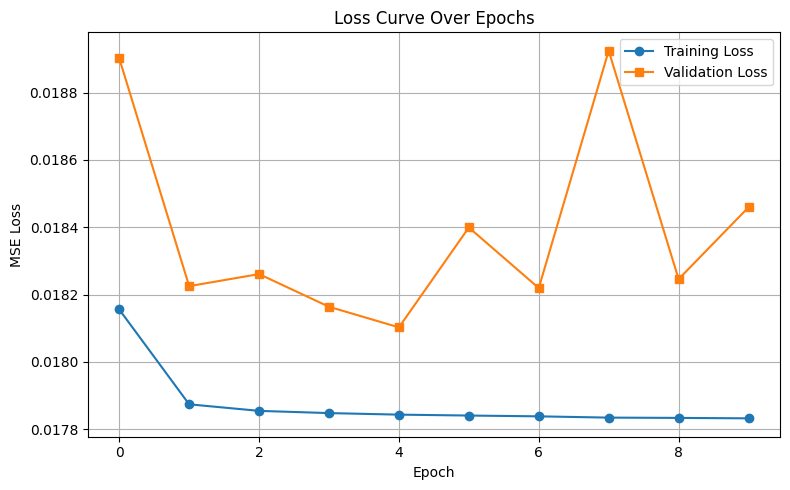

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')

if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')

plt.title("Loss Curve Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Example: Plot Prediction vs actual

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


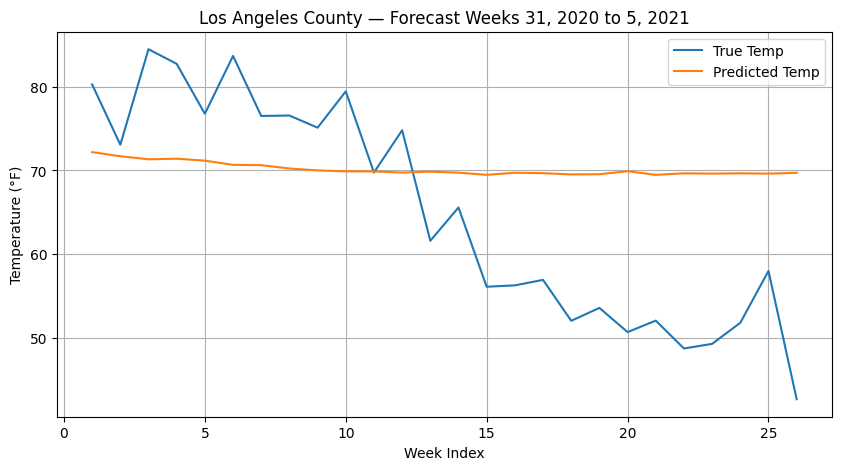

In [ ]:
# 1. Find columns for input (weeks 1–30, 2020) and output (weeks 31–52, 2020 + 1–5, 2021)
input_weeks = [f"{w}, 2020" for w in range(1, 31)]
target_weeks = [f"{w}, 2020" for w in range(31, 53)] + [f"{w}, 2021" for w in range(1, 5)]  # 22 + 4 = 26 weeks

# 2. Filter the row for Los Angeles county
la_row = df[df['county_name'].str.lower() == 'los angeles'].iloc[0]

# 3. Extract input and target series
x_la = la_row[input_weeks].values.astype(float)
y_la = la_row[target_weeks].values.astype(float)

# 4. Normalize using a per-county scaler
from sklearn.preprocessing import MinMaxScaler

scaler_la = MinMaxScaler()
scaled_x_la = scaler_la.fit_transform(x_la.reshape(-1, 1)).flatten()
scaled_y_la = scaler_la.transform(y_la.reshape(-1, 1)).flatten()

# 5. Reshape input for LSTM: (1, Tx, 1)
X_demo = scaled_x_la.reshape(1, 30, 1)
a0_demo = np.zeros((1, n_a))
c0_demo = np.zeros((1, n_a))

# Predict
predicted = model.predict([X_demo, a0_demo, c0_demo])[0]  # shape (26,)

# Inverse transform
predicted_real = scaler_la.inverse_transform(predicted.reshape(-1, 1)).flatten()
true_real = scaler_la.inverse_transform(scaled_y_la.reshape(-1, 1)).flatten()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 27), true_real, label="True Temp")
plt.plot(range(1, 27), predicted_real, label="Predicted Temp")
plt.title("Los Angeles County — Forecast Weeks 31, 2020 to 5, 2021")
plt.xlabel("Week Index")
plt.ylabel("Temperature (°F)")
plt.legend()
plt.grid(True)
plt.show()

# References
Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830. Retrieved May 18, 2025, from https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html  
Ng, A. (2023). Deep Learning Specialization. Coursera. https://www.coursera.org/specializations/deep-learning  
